In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [33]:
os.makedirs("outputs/visualizations", exist_ok=True)

df = pd.read_csv("ukpn-low-carbon-technologies-secondary.csv")

print("Shape of dataset:", df.shape)
print(df.head())


Shape of dataset: (17148, 15)
   LCT_Connections    Category      Type  Import  Export  \
0                9  Generation  Solar PV     0.0      26   
1               20  Generation  Solar PV     0.0      62   
2               19  Generation  Solar PV     0.0      70   
3                6  Generation  Solar PV     0.0      25   
4               11  Generation  Solar PV     0.0      49   

                    LicenceArea FunctionalLocation SecondarySubstationAlias  \
0  Eastern Power Networks (EPN)  EPN-S0000003U2266                   3U2266   
1  Eastern Power Networks (EPN)  EPN-S0000004U3525                   4U3525   
2  Eastern Power Networks (EPN)  EPN-S0000001U3050                   1U3050   
3  Eastern Power Networks (EPN)  EPN-S0000005U2265                   5U2265   
4  Eastern Power Networks (EPN)  EPN-S0000005U2211                   5U2211   

      Status Primary_FunctionalLocation             PrimaryFeeder  Latitude  \
0  Connected          EPN-S0000000H3036      J37 EAST B

In [34]:
# Export Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['Export'], bins=50, kde=True)
plt.title('Distribution of Export')
plt.savefig("outputs/visualizations/export_distribution.png")
plt.close()

# Export vs Category
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Category', y='Export')
plt.title('Export vs Category')
plt.xticks(rotation=45)
plt.savefig("outputs/visualizations/export_vs_category.png")
plt.close()

# Correlation Heatmap
numeric_cols = ['LCT_Connections', 'Import', 'Export']
corr = df[numeric_cols].corr()

plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.savefig("outputs/visualizations/correlation_heatmap.png")
plt.close()

In [35]:
df_model = df.drop(columns=[
    'Latitude', 'Longitude', 'geopoint',
    'Primary_FunctionalLocation', 'Status',
    'FunctionalLocation', 'SecondarySubstationAlias',
    'PrimaryFeeder'
])

X = df_model.drop(columns='Export')
y = df_model['Export']

categorical_cols = X.select_dtypes(include='object').columns.tolist()
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()


In [36]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'
)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [38]:
models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoost': XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}

In [39]:
results = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    print(f"\nTraining model: {name}")
    
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    neg_mse_scores = cross_val_score(
        pipeline, X_train, y_train,
        scoring='neg_mean_squared_error',
        cv=kf
    )
    rmse_scores = np.sqrt(-neg_mse_scores)
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    
    results.append({
        'Model': name,
        'CV Mean RMSE': rmse_scores.mean(),
        'CV Std RMSE': rmse_scores.std(),
        'Test RMSE': rmse,
        'Test MAE': mae
    })



Training model: LinearRegression

Training model: RandomForest

Training model: XGBoost


In [40]:
results_df = pd.DataFrame(results)
print("\nModel Comparison Results:")
print(results_df)


Model Comparison Results:
              Model  CV Mean RMSE  CV Std RMSE  Test RMSE  Test MAE
0  LinearRegression     19.862015     1.946790  12.889598  6.926494
1      RandomForest     20.551312     1.853233  15.018359  6.925377
2           XGBoost     19.962977     1.984103  13.718960  6.259513


In [42]:
results_df.to_csv("outputs/Model_Comparison.csv", index=False)

In [43]:
final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', models['XGBoost'])
])
final_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Category', 'Type',
                                                   'LicenceArea',
                                                   'LocalAuthority'])])),
                ('regressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, early_stopping_rounds=No...
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=42, ...))])

In [45]:
y_test_pred = final_pipeline.predict(X_test)

X_test_reset = X_test.reset_index(drop=True)
y_test_reset = y_test.reset_index(drop=True)

results_table = X_test_reset.copy()
results_table['True Export'] = y_test_reset
results_table['Predicted Export'] = y_test_pred

# Add residuals for analysis
results_table['Residual'] = results_table['True Export'] - results_table['Predicted Export']

# Select columns for presentation
presentation_columns = [
    'LocalAuthority', 'Category', 'Type', 'LicenceArea', 'LCT_Connections',
    'True Export', 'Predicted Export', 'Residual'
]

final_results = results_table[presentation_columns]


In [46]:
print("\nTop 10 Predictions:\n")
print(final_results.head(10))

# Save full predictions
final_results.to_csv("outputs/Option2_Predicted_Exports.csv", index=False)


Top 10 Predictions:

                  LocalAuthority    Category               Type  \
0             Sutton London Boro  Generation           Solar PV   
1         Brentwood District (B)      Demand  EV Charging Point   
2              Brent London Boro  Generation           Solar PV   
3      Castle Point District (B)  Generation           Solar PV   
4  Folkestone and Hythe District  Generation           Solar PV   
5   East Cambridgeshire District  Generation           Solar PV   
6                  Adur District  Generation           Solar PV   
7                    Bedford (B)  Generation           Solar PV   
8          Redbridge London Boro  Generation           Solar PV   
9   East Cambridgeshire District  Generation           Solar PV   

                          LicenceArea  LCT_Connections  True Export  \
0  South Eastern Power Networks (SPN)                7           23   
1        Eastern Power Networks (EPN)                6            0   
2         London Power Netw

In [47]:
# True vs Predicted
plt.figure(figsize=(8, 6))
sns.scatterplot(x=final_results['True Export'], y=final_results['Predicted Export'])
plt.plot([0, final_results['True Export'].max()], [0, final_results['True Export'].max()], '--', color='red')
plt.title('True Export vs Predicted Export')
plt.xlabel('True Export')
plt.ylabel('Predicted Export')
plt.savefig("outputs/visualizations/true_vs_predicted.png")
plt.close()

# Residuals distribution
plt.figure(figsize=(8, 6))
sns.histplot(final_results['Residual'], bins=50, kde=True)
plt.title('Residuals Distribution (True - Predicted)')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.savefig("outputs/visualizations/residuals_distribution.png")
plt.close()

# LocalAuthority errors
grouped_errors = final_results.groupby('LocalAuthority').apply(
    lambda df: np.mean(np.abs(df['Residual']))
).reset_index(name='Mean Absolute Error')

grouped_errors = grouped_errors.sort_values(by='Mean Absolute Error', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(data=grouped_errors, x='LocalAuthority', y='Mean Absolute Error')
plt.title('Top 10 LocalAuthorities with Highest Prediction Error')
plt.xticks(rotation=45)
plt.savefig("outputs/visualizations/local_authority_errors.png")
plt.close()

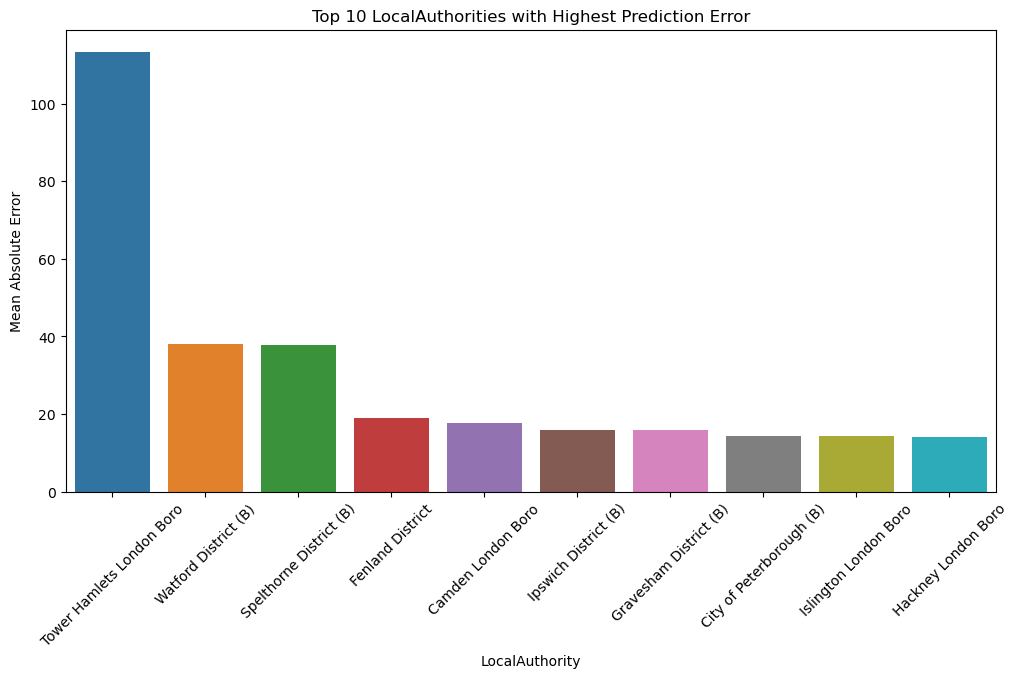

In [29]:
# Grouped error by LocalAuthority

grouped_errors = final_results.groupby('LocalAuthority').apply(
    lambda df: np.mean(np.abs(df['Residual']))
).reset_index(name='Mean Absolute Error')

# Sort top 10
grouped_errors = grouped_errors.sort_values(by='Mean Absolute Error', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(data=grouped_errors, x='LocalAuthority', y='Mean Absolute Error')
plt.title('Top 10 LocalAuthorities with Highest Prediction Error')
plt.xticks(rotation=45)
plt.show()